In [240]:
import numpy as np
import pandas as pd
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from utils import *
from sklearn.cluster import KMeans
from tqdm import tqdm
from sklearn.svm import SVC
from SVM import OVO_test, OVO_train
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [241]:
Xtr = pd.read_csv('data/Xtr.csv',header=None,sep=',',usecols=range(3072))
Xte = pd.read_csv('data/Xte.csv',header=None,sep=',',usecols=range(3072))
Ytr_ = pd.read_csv('data/Ytr.csv')#, index_col = None, header = None)

In [242]:
Xtr = np.array(Xtr).reshape(5000, 3,32, 32).swapaxes(1,2).swapaxes(2,3)
Xte = np.array(Xte).reshape(2000, 3,32, 32).swapaxes(1,2).swapaxes(2,3)
Ytr = np.array(Ytr_['Prediction'])

#Xtr_ = rgb2gray(Xtr)
#Xte_ = rgb2gray(Xte)

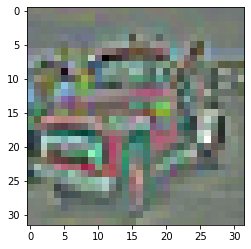

In [243]:
fig, ax = plt.subplots()
plot_image(Xtr[6], ax)

# Feature learning

In [244]:
test = extract_patches(Xtr[:1], num_patches = 50, patch_size=6)

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 340.58it/s]


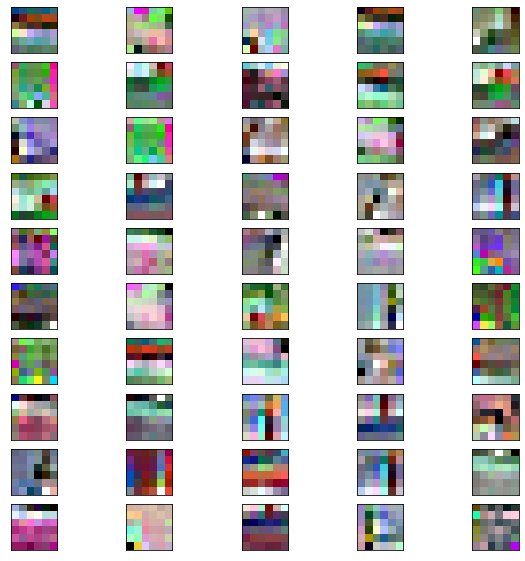

In [245]:
image = Xtrfig, ax = plt.subplots(10, 5, figsize=(10,10))
for idx in range(50):
    i = idx%10
    j = idx//10
    plot_image(test[0,idx], ax[i,j])
    ax[i,j].axes.xaxis.set_visible(False)
    ax[i,j].axes.yaxis.set_visible(False)
plt.show()

In [246]:
patches = extract_patches(Xtr, 200000, 6)

100%|██████████████████████████████████████| 5000/5000 [00:08<00:00, 558.49it/s]


In [247]:
patches = whiten_patches(patches)[0]

KeyboardInterrupt: 

In [ ]:
labels, centroids = cluster_patches(patches, 400)

In [ ]:
fig, ax = plt.subplots(20,20, figsize = (40,40))
idx = 0
for i in range(20):
    for j in range(20):
        plot_image(centroids[idx].reshape(6, 6, 3), ax[i,j])
        ax[i,j].axes.xaxis.set_visible(False)
        ax[i,j].axes.yaxis.set_visible(False)
        idx+=1

# Feature extraction

In [155]:
#dataset = Xtr_
#dataset.shape
X_train = compute_features(Xtr, centroids, stride=2, patch_size=6)
X_test = compute_features(Xte, centroids, stride=2, patch_size=6)

100%|███████████████████████████████████████| 2000/2000 [06:55<00:00,  4.81it/s]


<AxesSubplot:>

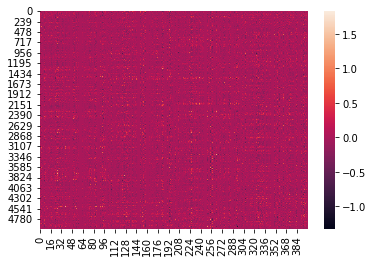

In [156]:
import seaborn as sns
sns.heatmap(X)

In [248]:
#np.save('X_train', X_train)
#np.save('X_test', X_test)

X_train = np.load('X_train.npy')
X_test= np.load('X_test.npy')

In [249]:

X_tr, X_te, y_tr, y_te = train_test_split(X_train, Ytr, test_size=0.33, random_state=42)

In [ ]:
classifier = SVC(C=1000, decision_function_shape='ovo')
classifier.fit(X_tr, y_tr)

In [ ]:
pred = classifier.predict(X_te)

In [ ]:
plt.hist(pred, alpha=0.3)
plt.hist(y_te, alpha=0.3)
plt.show()

In [ ]:
accuracy_score(pred, y_te)